# Example usage with cirq plots
This notebook shows some examples of generating Quantum Convolutional Neural Networks (QCNNs)

___
*A cute robot building itself with artifical intelligence, pencil drawing -  generated with* [Dall$\cdot$E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [1]:
# Load libraries
import sympy
import numpy as np

In [2]:
# Core library functionality
from dynamic_qcnn import (
    Qcnn,
    Qfree,
    Qconv,
    Qpool,
    Qdense,
    plot_graph
)

2022-12-02 11:16:55.126024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 11:16:55.126061: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 11:16:58.826841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-02 11:16:58.826881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 11:16:58.826927: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Enigma): /proc/driver/nvidia/version does not exist
2022-12-02 11:16:58.827570: I tensorflow/core/platform/cpu_feature_gua

In [3]:
# Specific to cirq
import cirq
from cirq.contrib.svg import SVGCircuit
from dynamic_qcnn.cirq import convert_graph_to_circuit_cirq, pretty_cirq_plot

### Basic example
We create one of the architectures discussed in [Lourens et al.](https://arxiv.org/pdf/2210.15073.pdf). This architecture is semantically described as repeating a convolution of stride 1 and pooling from bottom to top on 8 qubits until one remain.

<img src="../img/hierarchical_motifs.drawio.svg" alt="hierarchical motifs" width="900"/>

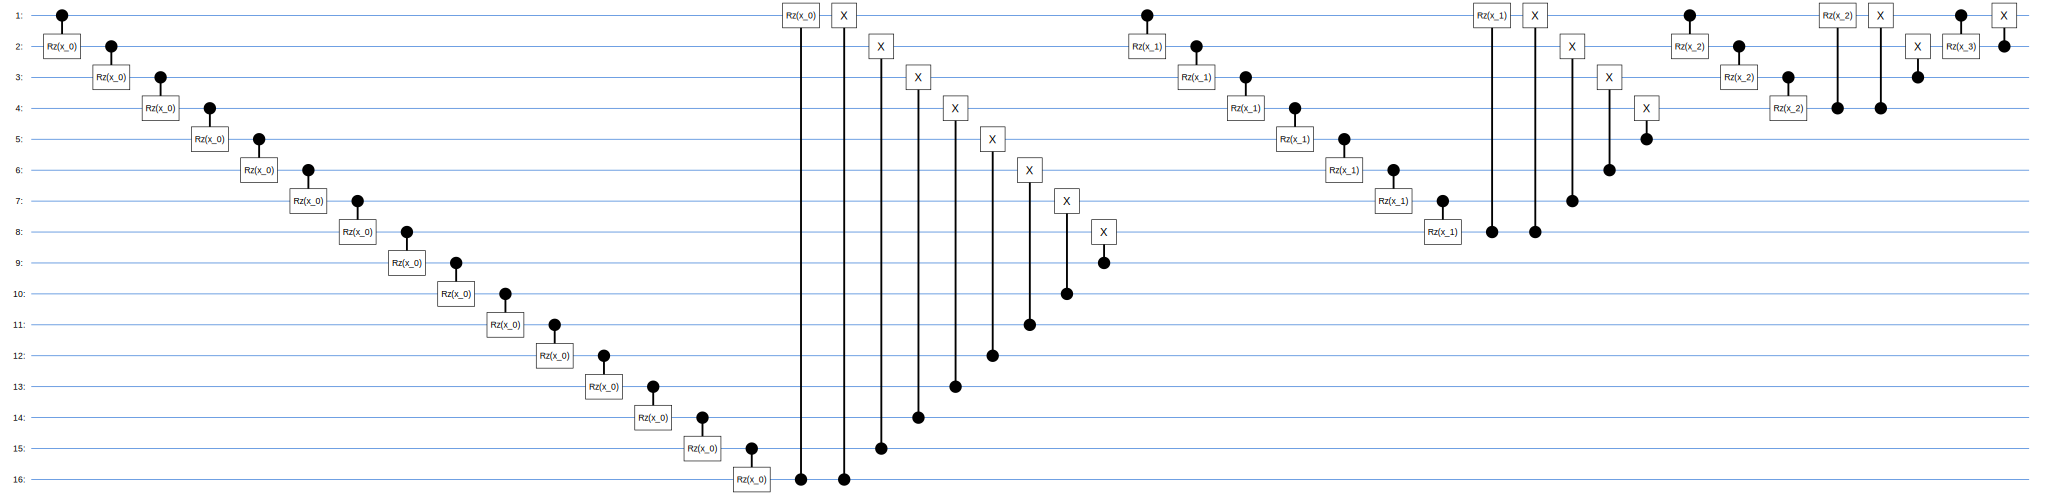

In [5]:
m = Qfree(16) + (Qconv(1) + Qpool(filter="right")) * 4

circuit, symbols = convert_graph_to_circuit_cirq(m)
SVGCircuit(circuit) 

### Building blocks
Circuit architectures are created by stacking motifs hierarchacially, the lowest level motifs (primitives) are building blocks for higher level ones. On a high level you can regard a primitive as a layer such as convolution or pooling and we're creating a sequence of layers for the circuit. This view only captures hierarchical architectures of two levels (*level 1 -> primitives, level 2 -> sequence of primitves*). The framework is more general in that there is no limit to the number of levels used to represent an architecture. See the comparison below:

**Layer view**
 - qcnn = (Convolution, Pooling, Convolution, Pooling, Convolution, Convolution, Convolution, Pooling, Convolution, Pooling)

**Hierarchical view**
 - m2_1 = (Convolution, Pooling)
 - m2_2 = (Convolution, Convolution)
 - m3_1 = (m2_1, m2_1)
 - qcnn = (m3_1, m2_2, m3_1)

#### Convolution primitive

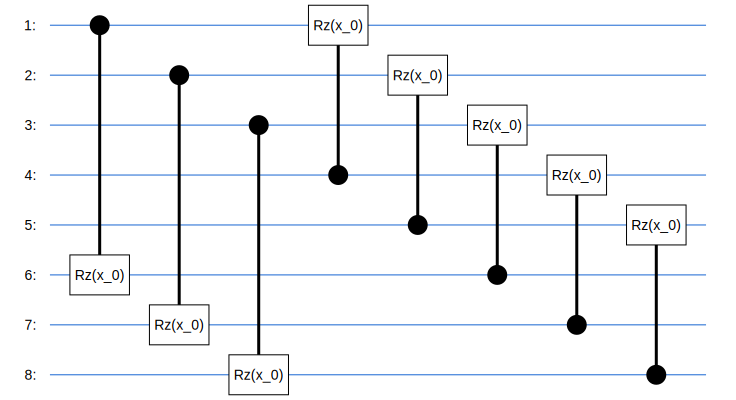

In [8]:
# Convolution of stride 3, try out other stride values
convolution = Qconv(5) 
conv_on_8_qubits = Qfree(8) + convolution

circuit, symbols = convert_graph_to_circuit_cirq(conv_on_8_qubits)
SVGCircuit(circuit)

#### Pooling primitive

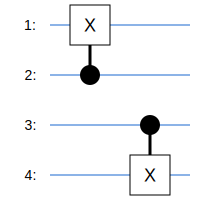

In [7]:
# Pooling from inside out, other values for filter: right, left, inside, outside, even, odd or a bitstring like 0100
pooling = Qpool(filter="inside")
pool_on_4_qubits = Qfree(4) + pooling

circuit, symbols = convert_graph_to_circuit_cirq(pool_on_4_qubits)
SVGCircuit(circuit)

#### Dense primitive

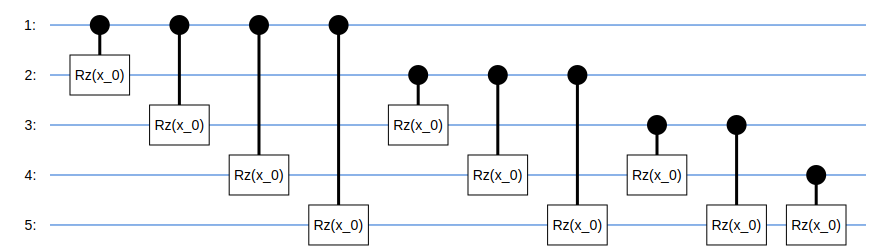

In [10]:
# Dense primitive, does all pairwise combinations between available qubits, for all permutations set permutations=True
dense = Qdense(permutations=False)
dense_on_5_qubits = Qfree(5) + dense

circuit, symbols = convert_graph_to_circuit_cirq(dense_on_5_qubits)
SVGCircuit(circuit)

#### Free qubit primitive

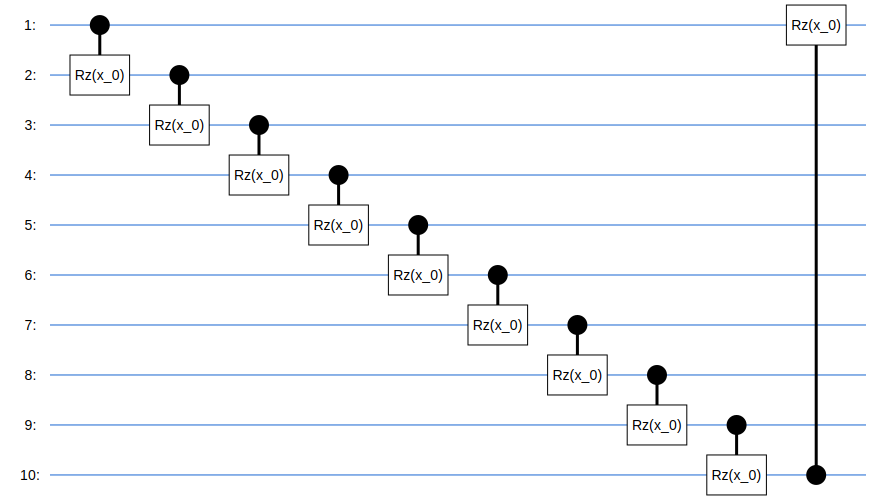

In [17]:
# Free primitive, can also recieve a list of qubit lables to make available.
free = Qfree(10)
convolution_on_10_qubits = free + Qconv(1)

circuit, symbols = convert_graph_to_circuit_cirq(convolution_on_10_qubits)
SVGCircuit(circuit)

## Reverse binary tree

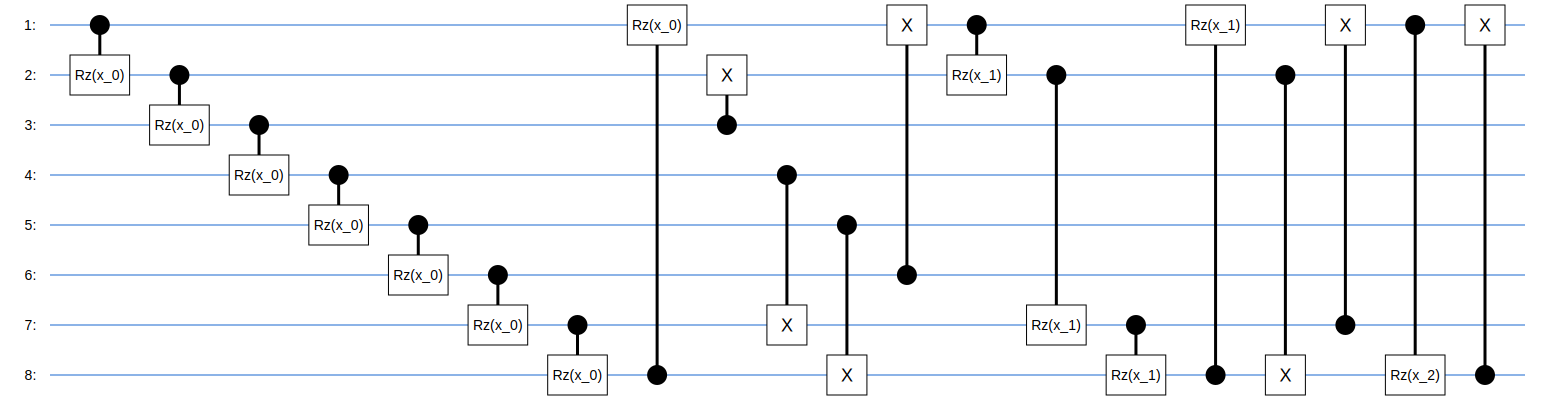

In [18]:
### Reverse binary tree

# Change these values
#---------
N = 8 # any power of two
s_c = 1 # 1,2,3, ...
f = "inside" # right, left, inside, outside, even, odd
s_p = 1 # 1,2,3, ...
#---------

# level 1
m1_1 = Qconv(stride=s_c)
m1_2 = Qpool(stride=s_p, filter=f)
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
# m3_1 + Qfree([1,3,5]) + Qconv(5)+m3_1)*4
SVGCircuit(circuit)

### More arbitrary examples to show what is possible

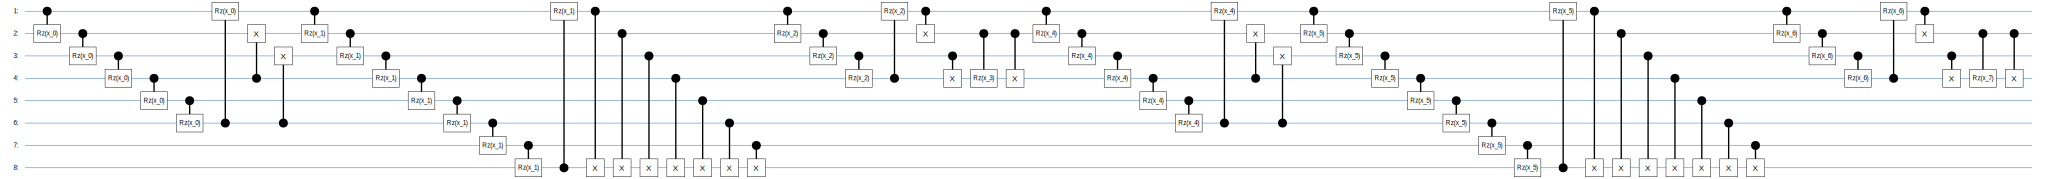

In [19]:
m1 = Qfree(6) + Qconv()
m2 = m1 + Qpool(1, "000101")
m3 = m2 + Qfree(8) + Qconv(1) + Qpool(2, "11111110")
m4 = m3 + Qfree(4) + (Qconv(1) + Qpool(0, "even")) * 2
m5 = m4 + m4
circuit, symbols = convert_graph_to_circuit_cirq(m5)
SVGCircuit(circuit)

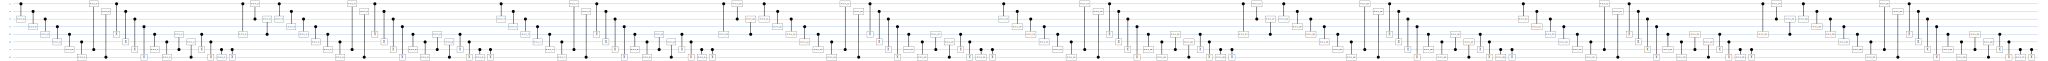

In [11]:
N = 8
# level 1
m1_1 = Qconv(2)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_cirq(
    (m3_1 + Qfree([1, 3, 5]) + Qconv(5) + m3_1) * 4
)
SVGCircuit(circuit)

## Multiscale Entanglement Renormalization Ansatz (MERA)

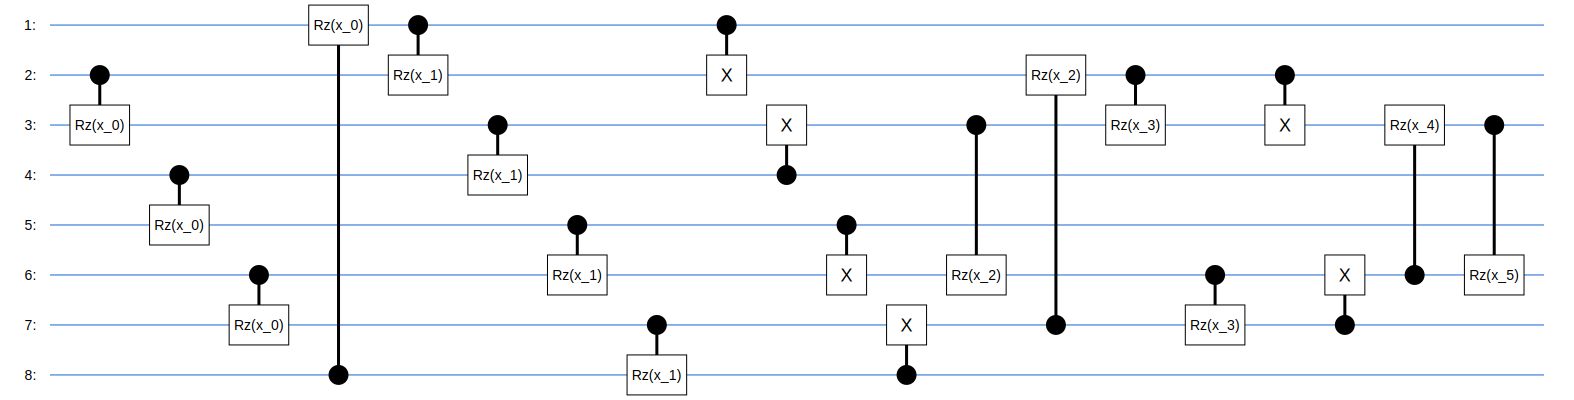

In [21]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
SVGCircuit(circuit)

## Random QCNNs

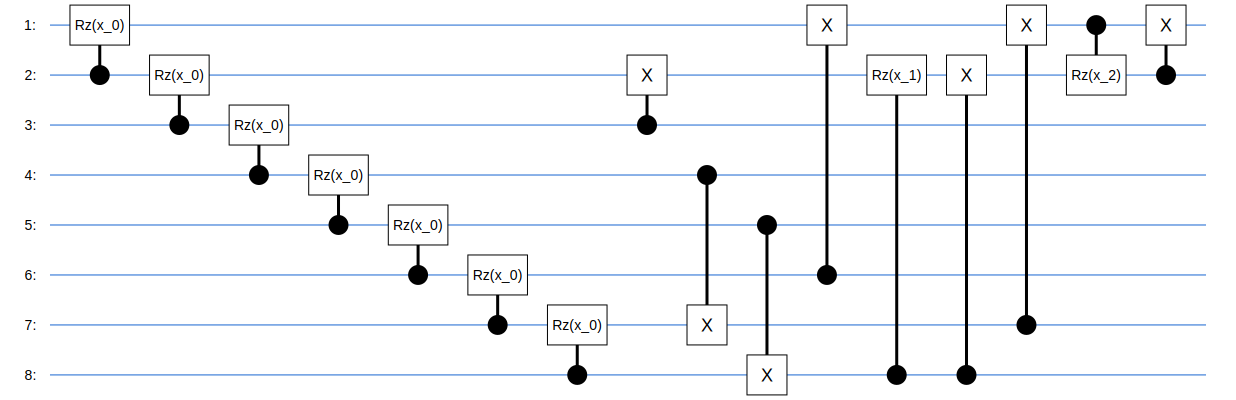

In [23]:
# More structure
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ]  # + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

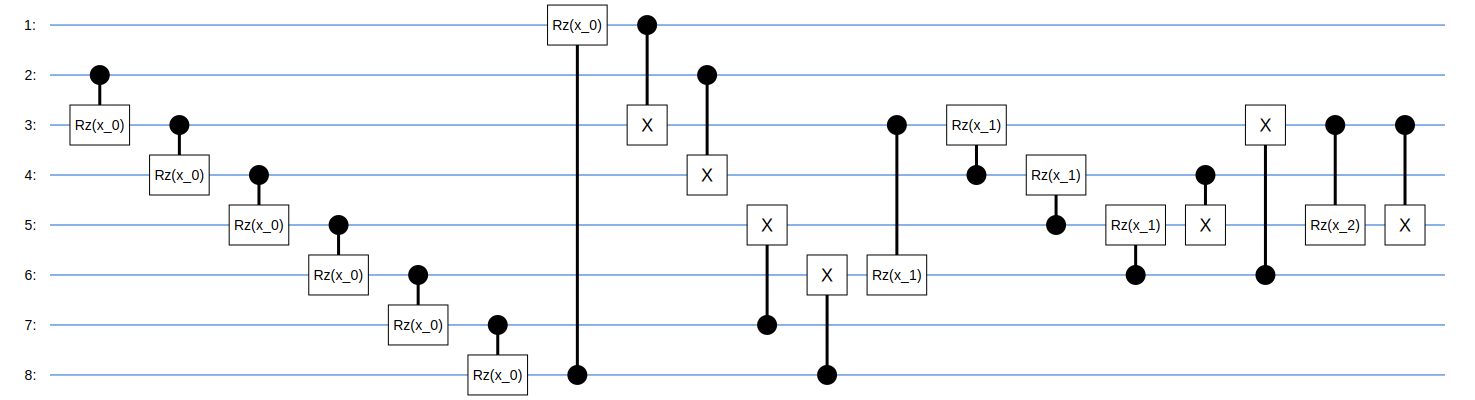

In [12]:
# loose
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ] + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

## Specifying unitaries

In [14]:
# Pooling circuit
def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[1]).on(q0)
    circuit += cirq.ry(symbols[2]).on(q1)
    circuit += cirq.CNOT(q0, q1)
    circuit += cirq.ry(symbols[3]).on(q1)
    return circuit


# Convolution circuit
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[1]).on(q0)
    circuit += cirq.ry(symbols[2]).on(q1)
    circuit += cirq.CNOT(q0, q1)
    circuit += cirq.ry(symbols[3]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[4]).on(q0)
    return circuit

In [15]:
M = (
    Qfree(8)
    + (
        Qconv(1, convolution_mapping=(U, 5))
        + Qpool(filter="left", pooling_mapping=(V, 4))
    )
    * 3
)
circuit, symbols = convert_graph_to_circuit_cirq(M)

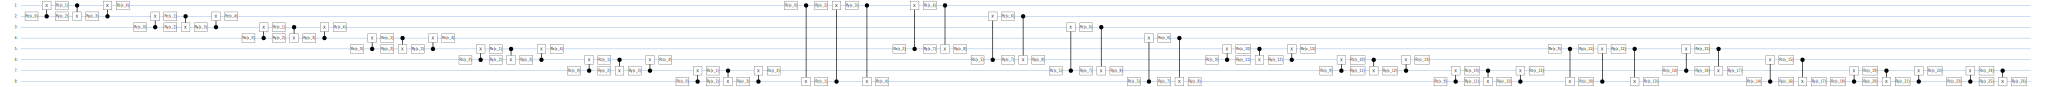

In [16]:
SVGCircuit(circuit)

### Cycle through unitary ansatzes

In [17]:
# Pooling circuit
def V_1(bits, symbols=None):  # 1
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rx(symbols[0]).on(q1).controlled_by(q0)

    return circuit


def V_2(bits, symbols=None):  # 0
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.CNOT(q0, q1)
    return circuit


# Convolution circuit
def U_1(bits, symbols=None):  # 1
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    return circuit


def U_2(bits, symbols=None):  # 1
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.ry(symbols[0]).on(q1).controlled_by(q0)
    return circuit


function_mappings = {
    "convolution": [(U_1, 1), (U_2, 1)],
    "pooling": [(V_1, 1), (V_2, 0)],
}

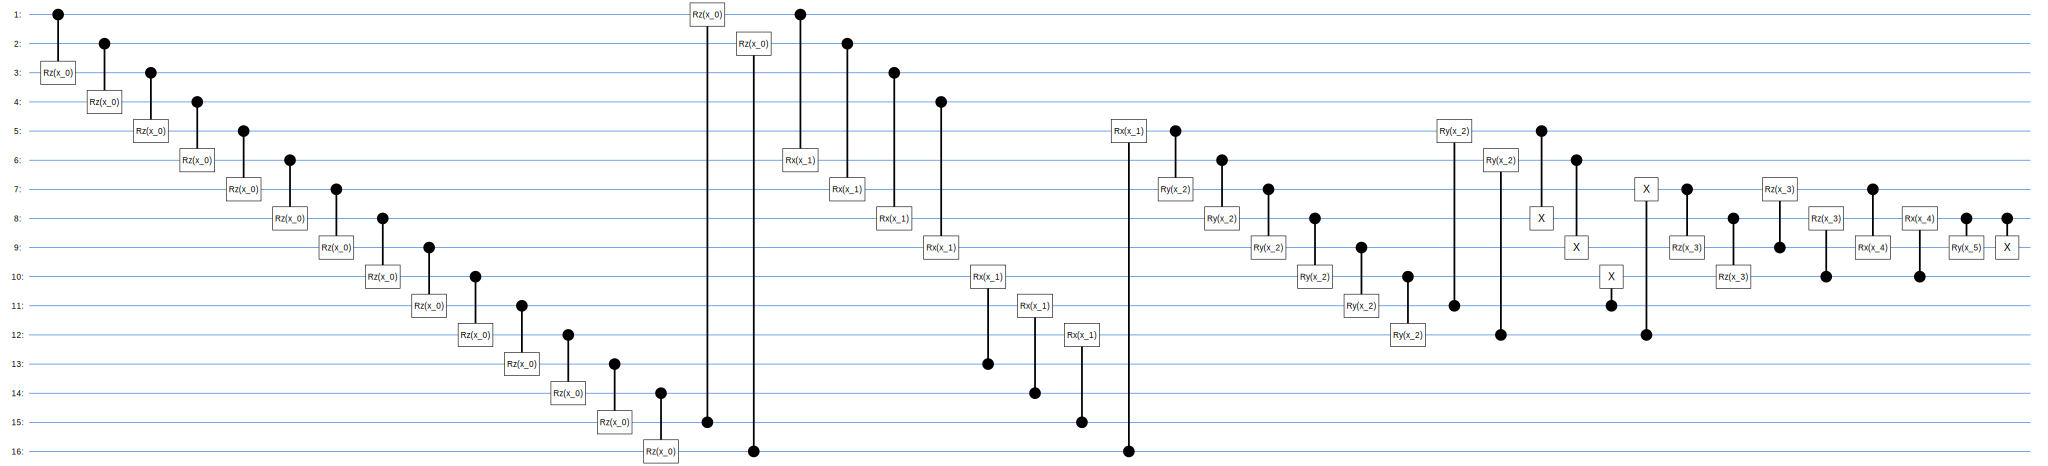

In [18]:
qcnn = Qcnn(16, function_mappings=function_mappings)

qcnn = qcnn + (Qconv(2) + Qpool(1, "outside")) * 4
circuit, symbols = convert_graph_to_circuit_cirq(qcnn)
SVGCircuit(circuit)

### Plot the graph view

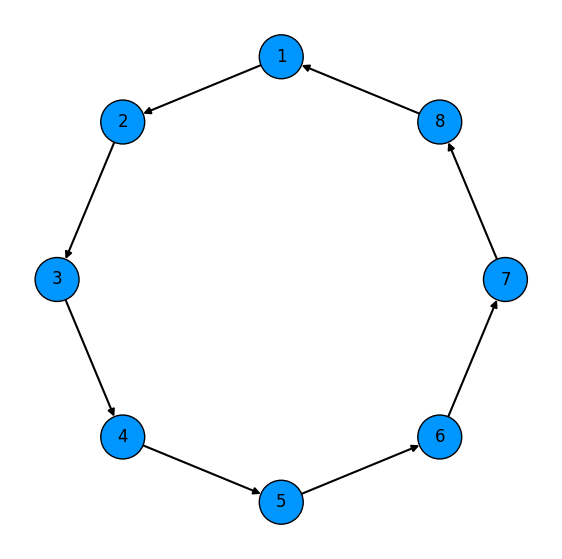

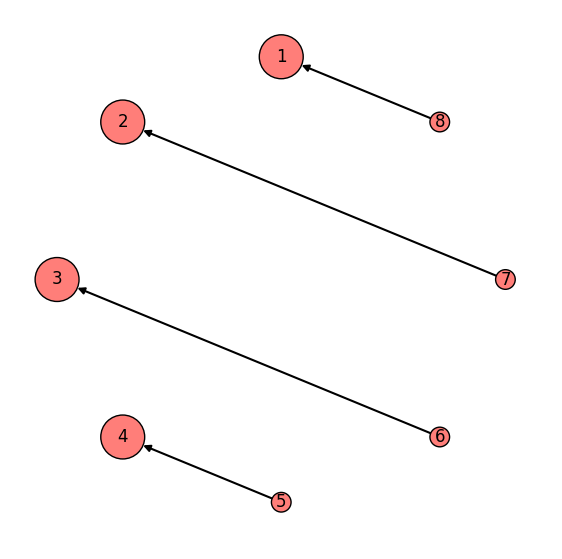

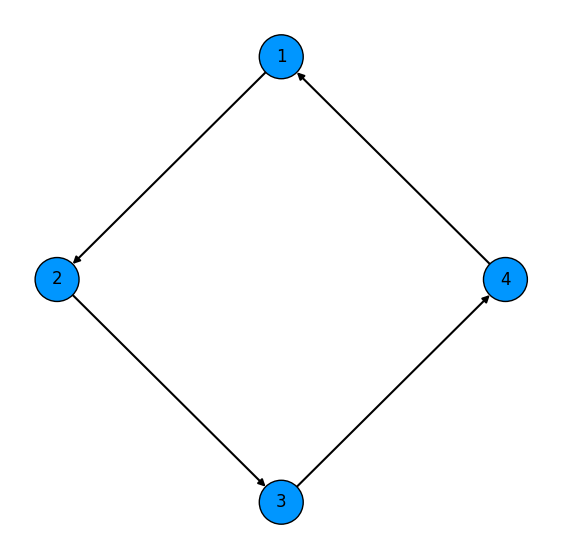

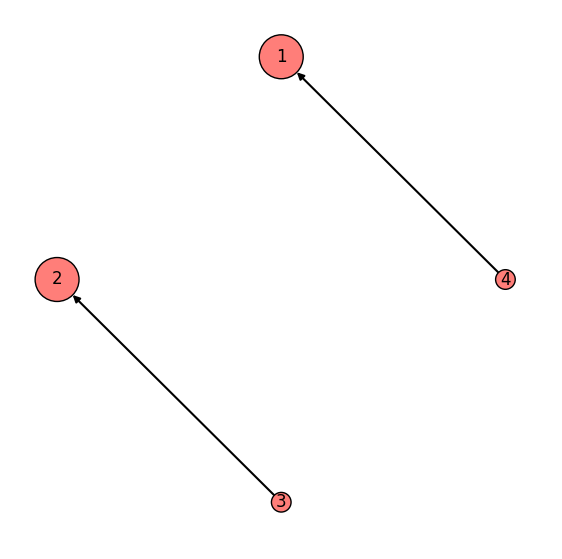

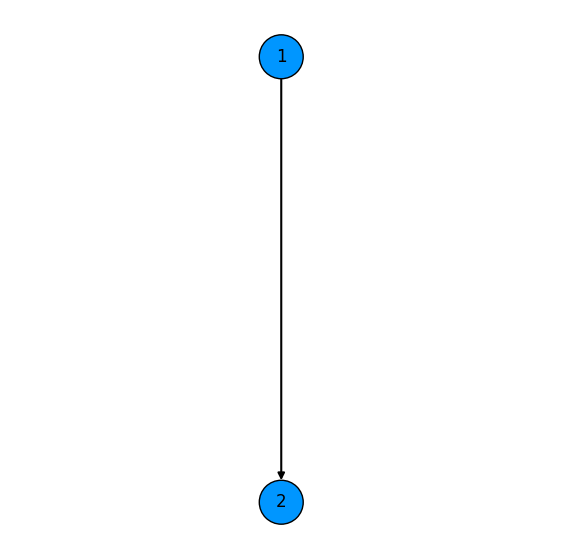

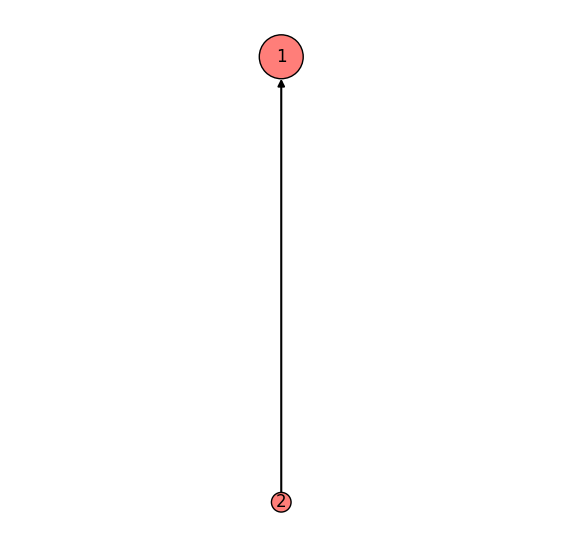

In [14]:
m = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3
for graph in m:
    a = plot_graph(graph)